<a href="https://colab.research.google.com/github/NataliaTarasovaNatoshir/NataliaTarasovaNatoshir/blob/main/find_insects_on_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task Description

# Overview
One of the frequent tasks that may arise in practice is the task of **finding images of a specific class for which you do not have a labeled dataset**. 

It may happen when there is a suspicion that an AI system performs poorly on the objects of specific type or characteristics. Or when you would like to gather a dataset of images of a particular type but labeling for this dataset is time and resource consuming. 

Examples:

*   In historical data find scenes with traffic cones to evaluate the performance of autonomous vehicle visual recognition system in these particular situations
*   Gather a dataset of photos of people in surgical masks to update a facial recognition model

The main obstacle is a complete lack of the labeled dataset. You know that you have images of the required type (scenes with traffic cones, photos of people wearing masks, etc.) in the database but they are rare and not labeled. 

# End Goal
The end goal is to develop a **system that can filter through an image database and find a subset that contains many objects of the desired class**. Resulting subset can be later sent for manual labeling so it does not have to be 100% accurate. However in many cases the required class is very small in size which means that sampling the database randomly will be extremely inefficient for labeling. For example, if the desired class is rare, say 1 in 100 images - it will take 10.000 images to label manualy to find just 100 images of the required type.

# Demo task description
Below is an example of this type of task and its possible solution on a small publicly available dataset. We will use photos of flowers as the database to filter through and try to find images that also contain insects - bees, flies, spiders, etc.

*Note*:
If you plan to run this notebook you will need to:


*   Mount your Google Drive for data storage
*   Spend 15-20 minutes manually labeling the images




# Load and label data

In [ ]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from google.colab import widgets
from IPython.display import clear_output

In [ ]:
print(tf.__version__)

2.7.0


## Load flowers dataset

This notebook uses a subset of the dataset of about 3,700 photos of flowers.

The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

 We will use images of classes "daisy" and "dandelion"

 *Note*: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True, cache_dir='~/keras')
data_dir = pathlib.Path(data_dir)

## Save daisies and dandelions images to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /tmp/.keras/datasets/flower_photos

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [ ]:
images_num = 0
for flower in ['daisy', 'dandelion']:
  flower_num = len(list(data_dir.glob('{}/*'.format(flower))))
  images_num += flower_num
  print('{}: {}'.format(flower, flower_num))
print('\nTotal number of images: {}'.format(images_num))

daisy: 633
dandelion: 898

Total number of images: 1531


On mounted Google Drive we will make a directory "flower_dataset" for this task and store all images in "unlabeled" directory

In [ ]:
!mkdir "/content/drive/MyDrive/Colab Notebooks/flower_dataset/"
!mkdir "/content/drive/MyDrive/Colab Notebooks/flower_dataset/unlabeled"
!cp -rf /tmp/.keras/datasets/flower_photos/daisy/* "/content/drive/MyDrive/Colab Notebooks/flower_dataset/unlabeled"
!cp -rf /tmp/.keras/datasets/flower_photos/dandelion/* "/content/drive/MyDrive/Colab Notebooks/flower_dataset/unlabeled"

In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/flower_dataset/unlabeled")
print('Total number of images on Google Drive: {}'.format(len(list(data_dir.glob('*')))))

Total number of images on Google Drive: 1531


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/flower_dataset"

Here's a typical example of an image in the dataset we are working with:

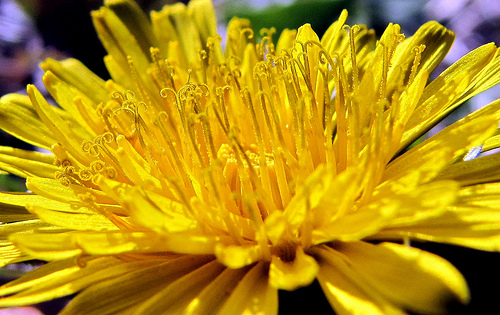

In [ ]:
image_example_name = '4336536446_e635f48f2e.jpg'
im = PIL.Image.open(os.path.join(DATA_DIR, 'unlabeled', image_example_name))
display(im)

Let`s look at some of the examples of the rare class we want to find in the data - images with different insects like bees, spiders, ants, butterflies, etc. 

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

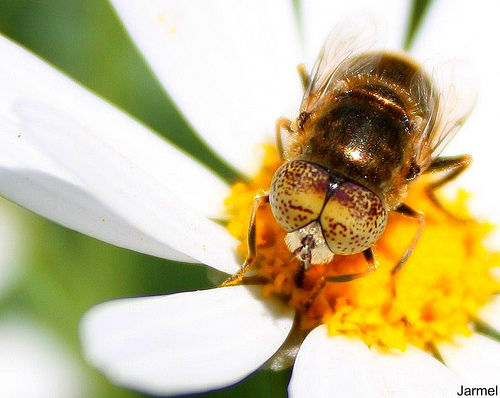

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

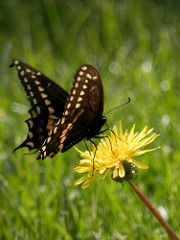

<IPython.core.display.Javascript object>

In [ ]:
im_0 = PIL.Image.open(os.path.join(DATA_DIR, 'unlabeled', '3337643329_accc9b5426.jpg'))
im_1 = PIL.Image.open(os.path.join(DATA_DIR, 'unlabeled', '10477378514_9ffbcec4cf_m.jpg'))
grid = widgets.Grid(1, 2, header_row=False, header_column=False)
with grid.output_to(0, 0):
  display(im_0)
with grid.output_to(0, 1):
  display(im_1)

## Separate data for testing and for manual labelling

To develop a model we need to create an initial labeled dataset (it can be small in size) and select some data we will use later for testing our approach.

So let`s separate our data into 3 folders:


1.   "labeled" - data for model training that we need to label manually
2.   "test" - data that we will use for testing our approach later
2.   "unlabeled" - remaining data that is left unlabeled

In [ ]:
import shutil

def move_files_by_names(file_names, src_folder, dest_folder, clear_dest_dir_if_exist=True, copy_src=False):
  if not clear_dest_dir_if_exist:
    os.makedirs(dest_folder, exist_ok=True)
  else:
    try:
      os.makedirs(dest_folder, exist_ok=False)
    except IOError or FileExistsError as io_err:
      shutil.rmtree(dest_folder, ignore_errors=True)
      os.makedirs(dest_folder, exist_ok=False)
  for file_name in file_names:
    if copy_src == False:
      shutil.move(os.path.join(src_folder, file_name), dest_folder)
    else:
      shutil.copy(os.path.join(src_folder, file_name), dest_folder)

In [ ]:
TEST_SHARE = 0.4
LABELED_NUM = 300
SEED = 42

import random
all_files_names = os.listdir(os.path.join(DATA_DIR, 'unlabeled'))
dataset_size = len(all_files_names)

random.seed(SEED)
test_files_names = random.sample(all_files_names, int(TEST_SHARE*len(all_files_names)))
move_files_by_names(file_names=test_files_names, src_folder=os.path.join(DATA_DIR, 'unlabeled'), dest_folder=os.path.join(DATA_DIR, 'test'))

all_files_names = os.listdir(os.path.join(DATA_DIR, 'unlabeled'))
labeled_files_names = random.sample(all_files_names, LABELED_NUM)
move_files_by_names(file_names=labeled_files_names, src_folder=os.path.join(DATA_DIR, 'unlabeled'), dest_folder=os.path.join(DATA_DIR, 'labeled'))

assert dataset_size == len(os.listdir(os.path.join(DATA_DIR, 'unlabeled'))) + \
len(os.listdir(os.path.join(DATA_DIR, 'test'))) + len(os.listdir(os.path.join(DATA_DIR, 'labeled')))

In [ ]:
print("{} images for initial labeling\n{} images for model testing\n{} unlabeled images".format(LABELED_NUM, 
                                                                                                len(os.listdir(os.path.join(DATA_DIR, 'test'))), 
                                                                                                len(os.listdir(os.path.join(DATA_DIR, 'unlabeled')))))

300 images for initial labeling
612 images for model testing
619 unlabeled images


## Data labeling

Here we set up a process of manual labeling for images and manually label a small subset of them (300 images). This subset is stored in "labeled" directory and will be used for initial model training. 

We may assign two possible labels to an image:


0.   No insects in the image
2.   Image contains insects - bees, flies, spiders, ants, etc.



In [ ]:
def label_images(images_dir, max_images_num=None):
  file_names = os.listdir(images_dir)
  i = 0
  if max_images_num == None:
    max_num = len(file_names)
  else:
    max_num = max_images_num
  labels = []

  print('Starting labeling from {}th image\n'.format(i))
  while i < max_num:
    image_id = file_names[i]
    im = PIL.Image.open(os.path.join(images_dir, image_id))
    print("Image {} out of {}\n".format(i+1, max_num))
    print("Label the image:")
    print("0 - No insects in the picture\n1 - Insects in the picture (bees, flies, spiders, ants, etc.)")
    grid = widgets.Grid(2, 2, header_row=True, header_column=True)
    with grid.output_to(1, 1):
      display(im)
    with grid.output_to(0, 0):
      userinput = input()
    clear_output(wait=True)
    
    i += 1
    if userinput not in ('0', '1'):
      print('Incorrect input. Please try again')
      time.sleep(3)
      clear_output()
      i -= 1
    else:
      if userinput == '1': labels.append(image_id)

  return list(set(labels)), i

We are ready to manually label an initial dataset of images. This process takes 10-15 minutes.

Image 300 out of 300

Label the image:
0 - No insects in the picture
1 - Insects in the picture (bees, flies, spiders, ants, etc.)


,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

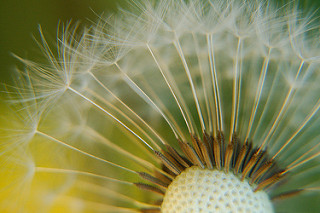

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0


<IPython.core.display.Javascript object>

In [ ]:
labeled_dir = os.path.join(DATA_DIR, 'labeled')
insects_images, i = label_images(images_dir=labeled_dir)

In [ ]:
# store images with insects in a separate folder 'labeled/insect'
l = len(os.listdir(os.path.join(DATA_DIR, 'labeled')))
move_files_by_names(file_names=insects_images, src_folder=os.path.join(DATA_DIR, 'labeled'), dest_folder=os.path.join(DATA_DIR, 'labeled/insect'))

In [ ]:
# store images without insects in a separate folder 'labeled/no_insects'
no_insect_images = list(os.walk(os.path.join(DATA_DIR, 'labeled')))[0][2]
move_files_by_names(file_names=no_insect_images, src_folder=os.path.join(DATA_DIR, 'labeled'), dest_folder=os.path.join(DATA_DIR, 'labeled/no_insects'))
assert l == len(os.listdir(os.path.join(DATA_DIR, 'labeled', 'insect'))) + len(os.listdir(os.path.join(DATA_DIR, 'labeled', 'no_insects')))

Random sample of images contains approximately 10% of images with insects 

In [ ]:
INSECTS_IMAGE_SHARE = len(insects_images) / l
print("{0} images with insects out of {1} images ({2:.0f}%)".format(len(insects_images), l, 100 * INSECTS_IMAGE_SHARE))

27 images with insects out of 300 images (9%)


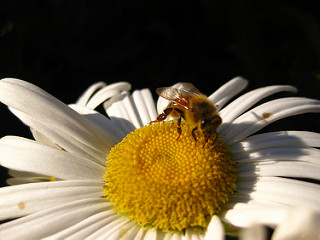

In [ ]:
im = PIL.Image.open(os.path.join(DATA_DIR, 'labeled', 'insect', insects_images[0]))
display(im)

# Setup a working pipeline

It is a good practice to **setup a working pipeline of testing before developing any model**. Deep-learning solutions are usually difficult to debug so it is essential to debug other elements of the pipeline first.

Here we formalize the process of testing for a model that filters through the database and produces a subset of objects that contain many images of the desired rare class. 

In this case testing proceeds as follows:


1.   **Apply the model to the test dataset.** In our case it consists of images in the "test" folder. This is a random sample from our original dataset of flowers. It contains 612 unlabeled images with and without insects. No images from this folder are used for model training or hyperparameters tuning.
2.   **Select top-50 images with the highest probability** of the "insects in the image"-class predicted by the model. These are the images that our model thinks may have insects in them.
2.   **Check how many images in top-50 actually contain insects**. To do that we label these images manually. That way we can understand how efficiently our model can find objects of the required rare class. We already have a benchmark: approximally 10% of images contain insects when we sample images randomly.



In [ ]:
import math
import seaborn as sns

def check_filtering(model, from_directory=True, img_path=None, img_dataset=None, sample_size=50, use_uncertainty_measure=False, return_img_names=False):

  # create a dataset from directory if from_directory=True
  print('Preparing dataset for prediction')
  if from_directory:
    if not img_path:
      img_directory = os.path.join(DATA_DIR, 'test')
    else:
      img_directory = img_path
    test_images = tf.keras.utils.image_dataset_from_directory(img_directory, labels=None, shuffle=False, )
  else:
    test_images = img_dataset

  # get model predictions
  print('Generating predictions')
  predictions = model.predict(test_images)

  # collect top-sample_size images with the highest score or uncertainty measure
  print('Selecting images for labeling')
  pred_df = pd.DataFrame({'predict_proba': predictions.flatten(), 'file_path': test_images.file_paths})
  if use_uncertainty_measure:
    sorting_col = 'uncertainty'
    pred_df['uncertainty'] = pred_df['predict_proba'].apply(lambda x: (x-1) * math.log(1-x) - x * math.log(x))
  else:
    sorting_col = 'predict_proba'
  
  pred_df.sort_values(sorting_col, ascending=False, inplace=True)
  pred_df = pred_df.head(sample_size)
  pred_df['file_path'] = pred_df['file_path'].apply(lambda x: str(os.path.basename(x)))
  imgs_for_labeling = pred_df['file_path'].values
  l = len(os.listdir(img_directory))
  move_files_by_names(file_names=imgs_for_labeling, src_folder=img_directory, 
                      dest_folder=os.path.join(DATA_DIR, 'temp_check'), clear_dest_dir_if_exist=True, copy_src=True)
  assert len(os.listdir(img_directory)) == l
  assert len(os.listdir(os.path.join(DATA_DIR, 'temp_check'))) == sample_size

  # ask user to label the images
  first_class_images, i = label_images(images_dir=os.path.join(DATA_DIR, 'temp_check'))

  # save information on manual labeling
  first_class_df = pd.DataFrame({'file_path': first_class_images})
  first_class_df['class_1'] = True
  pred_df = pd.merge(pred_df, first_class_df, how='left', on='file_path')
  pred_df['class_1'].fillna(False, inplace=True)

  # show sample statistics
  print('Generated predictions for {} images'.format(len(predictions)))
  plt.title('Predicted probability histogram')
  plt.xlabel('1-class predicted probability')
  sns.histplot(predictions)
  plt.show()
  first_class_share = len(first_class_images) / sample_size
  if use_uncertainty_measure:
    print('\nLabeled images with the highest uncertainty measure:')
  else:
    print('\nLabeled images with the highest first class probability:')
  print('\t{} images labeled'.format(sample_size))
  print('\t{0} ({1:.0f}%) of images of the first class in top-{2} sample:'.format(
      len(first_class_images), 100 * first_class_share, sample_size))

  if return_img_names:
    return pred_df, first_class_images
  else:
    return pred_df

Let`s see how our testing pipeline works. We may start with a "dummy" model that is untrained. It assigns probability of the first class (images with insects) randomly. We know that approximally 10% of images contain insects when we sample images randomly. So we expect to have the same share of images of the first class in top-50 objects selected by this model. 

In [ ]:
dummy_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1), 
  tf.keras.layers.Activation('sigmoid')
])

dummy_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Generated predictions for 612 images


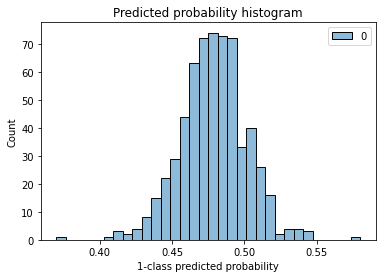


Labeled images with the highest first class probability:
	50 images labeled
	9 (18%) of images of the first class in top-50 sample:


In [ ]:
insects_images_dummy = check_filtering(model=dummy_model, sample_size=50)

As expected our untrained model is as efficient in finding objects of the required class as the random sampling of images.

# Develop a model for classification

We are very limited by the small size of our labeled dataset. We only have approximately 30 labeled images with insects. 

Nevertheless, let`s see if it is still possible to develop a model that finds objects of the required class significantly more efficiently than random sampling does.

In [ ]:
IMAGE_SHAPE = (224, 224)
batch_size = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(DATA_DIR, 'labeled'),
  label_mode='binary',
  class_names=['no_insects', 'insect'],
  validation_split=None,
  batch_size=batch_size
)

Found 300 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Transfer learning

We certainly do not have enough data to train a custom CNN from scratch. 

Instead we may use transfer learning: 

1.   Take a CNN that has been trained on huge datasets of images like ImageNet or COCO
2.   Remove its "head" and replace it with a layer suitable for our classification problem
2.   Train this additional layer on the small dataset that we have

*Note*: It is possible to find a pre-trained CNN that is already trained to distinguish insects. We do not use this approach here because this particular task is used as an example of real-life problems when the smallest class is not that straightforward. 

In [ ]:
import tensorflow_hub as hub

# take a "headless" CNN from tensorflow_hub
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [ ]:
# convert this model into an untrainable layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=IMAGE_SHAPE+(3,),
    trainable=False)

In [ ]:
# add a layer suitable for binary classification and layers for image preprocessing - resizing and rescaling
model = tf.keras.Sequential([
                             tf.keras.layers.Resizing(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1]),
                             tf.keras.layers.Rescaling(1./255),
                             feature_extractor_layer,
                             tf.keras.layers.Dense(1)
])

In [ ]:
# define optimization, loss and quality metrics for the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.keras.metrics.BinaryAccuracy())

In [ ]:
# train the model on our dataset
NUM_EPOCHS = 30

history = model.fit(train_ds, epochs=NUM_EPOCHS)

Epoch 1/30
10/10 [==============================] - 16s 1s/step - loss: 0.5431 - binary_accuracy: 0.8000
Epoch 2/30
10/10 [==============================] - 7s 737ms/step - loss: 0.2964 - binary_accuracy: 0.9100
Epoch 3/30
10/10 [==============================] - 7s 739ms/step - loss: 0.2951 - binary_accuracy: 0.9100
Epoch 4/30
10/10 [==============================] - 7s 735ms/step - loss: 0.2632 - binary_accuracy: 0.9100
Epoch 5/30
10/10 [==============================] - 8s 740ms/step - loss: 0.2351 - binary_accuracy: 0.9100
Epoch 6/30
10/10 [==============================] - 8s 740ms/step - loss: 0.2215 - binary_accuracy: 0.9100
Epoch 7/30
10/10 [==============================] - 8s 739ms/step - loss: 0.2098 - binary_accuracy: 0.9100
Epoch 8/30
10/10 [==============================] - 7s 736ms/step - loss: 0.1983 - binary_accuracy: 0.9100
Epoch 9/30
10/10 [==============================] - 7s 734ms/step - loss: 0.1881 - binary_accuracy: 0.9133
Epoch 10/30
10/10 [====================

In [ ]:
# add a layer to provide probability of the first class instead of logits
transfer_model = tf.keras.Sequential([model, tf.keras.layers.Activation('sigmoid')])

Generated predictions for 612 images


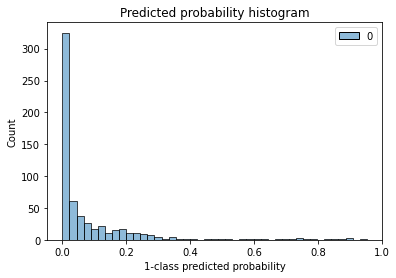


Labeled images with the highest first class probability:
	50 images labeled
	29 (58%) of images of the first class in top-50 sample:


In [ ]:
# evaluate the model ability to find objects of the required small class
insects_images_transfer = check_filtering(model=transfer_model, sample_size=50)

This model is much more efficient in finding objects of the required small class than random sampling! 

Unfortunately, it is still not perfect for the task. We can see that it confuses images of different classes when the predicted first-class probability is 0.2 - 0.6

In [ ]:
insects_images_transfer.head(50)

,predict_proba,file_path,class_1
0,0.953459,3337643329_accc9b5426.jpg,True
1,0.939444,6983113346_21551e1b52_n.jpg,True
2,0.908557,139124974_9e3ba69f6c.jpg,True
3,0.894455,4610018126_21f438d2dc_m.jpg,True
4,0.892681,2611119198_9d46b94392.jpg,True
5,0.876955,2481823240_eab0d86921.jpg,True
6,0.856312,154332674_453cea64f4.jpg,True
7,0.838827,7377004908_5bc0cde347_n.jpg,True
8,0.776593,18442919723_d1251d3e14_n.jpg,True
9,0.773795,16527403771_2391f137c4_n.jpg,True


## Active learning



### How to improve model performance?
Our main issue is the tiny size of our training dataset - around 30 objects of the smallest class. Its small size also limits our ability to use a separate dataset for validation to measure overfitting and tune hyperparameters (learning rate, early-stopping, dropout rate, etc.) It means that now the most effective way to improve out model performance is to gather more data.

### How to efficiently get more data?
The only way to get mode data is manual labeling of additional images. Is there an efficient way to boost model quality with minimum additional labeling? We can use **active learning** approach. Let`s label images from the unlabeled dataset where our model is uncertain. This is a way to efficiently apply labeling efforts.

The proposed solution is to use our model on unlabeled data:


1.   **Apply the model to the unlabeled dataset.** It consists of the images in the "unlabeled" folder. This is a random sample from our original dataset of flowers. It contains 619 unlabeled images with and without insects. These images have not been previously used for model training or testing.
2.   **Select top-100 images with the highest uncertainty measure**. If p is the predicted probability of the first class, than its uncertainty measure is \(p-1)log(1-p)-p*log(p).
2.   **Manually label all images in top-100 uncertainty measure group** and add these images to the training dataset.   



Generated predictions for 619 images


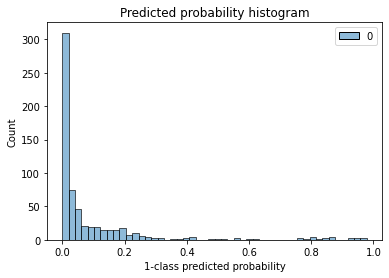


Labeled images with the highest uncertainty measure:
	100 images labeled
	23 (23%) of images of the first class in top-100 sample:


In [ ]:
# apply the model on unlabeled dataset and label top-100 images manually
new_insects_df, new_insects_images = check_filtering(model=transfer_model, from_directory=True, 
                                                     img_path=os.path.join(DATA_DIR, 'unlabeled'), return_img_names=True, sample_size=100, 
                                                     use_uncertainty_measure=True)

In [ ]:
# move 100 newly labeled images to the training folder
move_files_by_names(file_names=new_insects_images, src_folder=os.path.join(DATA_DIR, 'unlabeled'), 
                    dest_folder=os.path.join(DATA_DIR, 'labeled', 'insect'), clear_dest_dir_if_exist=False, copy_src=False)
new_no_insects_images = set(os.listdir(os.path.join(DATA_DIR, 'temp_check'))) - set(new_insects_images)
move_files_by_names(file_names=new_no_insects_images, src_folder=os.path.join(DATA_DIR, 'unlabeled'), 
                    dest_folder=os.path.join(DATA_DIR, 'labeled', 'no_insects'), clear_dest_dir_if_exist=False, copy_src=False)

In [ ]:
# prepare training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(DATA_DIR, 'labeled'),
  label_mode='binary',
  class_names=['no_insects', 'insect'],
  validation_split=None,
  batch_size=batch_size
)

Found 400 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# create and compile the model 
model = tf.keras.Sequential([
                             tf.keras.layers.Resizing(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1]),
                             tf.keras.layers.Rescaling(1./255),
                             feature_extractor_layer,
                             tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.keras.metrics.BinaryAccuracy())

In [ ]:
# train the model
NUM_EPOCHS = 30

history = model.fit(train_ds, epochs=NUM_EPOCHS)

Epoch 1/30
13/13 [==============================] - 13s 793ms/step - loss: 0.4992 - binary_accuracy: 0.8400
Epoch 2/30
13/13 [==============================] - 10s 751ms/step - loss: 0.4018 - binary_accuracy: 0.8750
Epoch 3/30
13/13 [==============================] - 10s 751ms/step - loss: 0.3330 - binary_accuracy: 0.8750
Epoch 4/30
13/13 [==============================] - 10s 752ms/step - loss: 0.2965 - binary_accuracy: 0.8750
Epoch 5/30
13/13 [==============================] - 10s 754ms/step - loss: 0.2653 - binary_accuracy: 0.8775
Epoch 6/30
13/13 [==============================] - 10s 748ms/step - loss: 0.2425 - binary_accuracy: 0.8900
Epoch 7/30
13/13 [==============================] - 10s 753ms/step - loss: 0.2259 - binary_accuracy: 0.9000
Epoch 8/30
13/13 [==============================] - 10s 747ms/step - loss: 0.2124 - binary_accuracy: 0.9075
Epoch 9/30
13/13 [==============================] - 10s 746ms/step - loss: 0.2015 - binary_accuracy: 0.9175
Epoch 10/30
13/13 [=========

In [ ]:
# add a layer to provide probability of the first class instead of logits
new_transfer_model = tf.keras.Sequential([model, tf.keras.layers.Activation('sigmoid')])

Generated predictions for 612 images


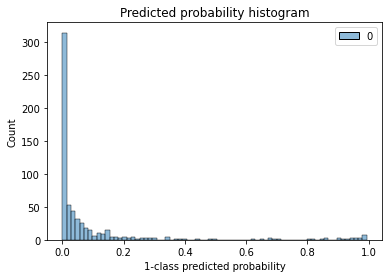


Labeled images with the highest first class probability:
	50 images labeled
	38 (76%) of images of the first class in top-50 sample:


In [ ]:
# evaluate the model ability to find objects of the required small class
new_insects_images_share_transfer = check_filtering(model=new_transfer_model, sample_size=50)

Our updated model is more efficient than the previous model in finding the objects of the rare class!

This process of "applying the model to the unlabeled dataset and manually labeling top-100 images with the highest uncertainty" may be repeated. Unfortunately, each iteration will yield fewer and fewer objects with high uncertainty measure.

# Conclusion

Our goal was to develop a way to efficiently scan a database and find objects of the rare class.

Using transfer learning, active learning approach and a moderate amount of manual labeling we managed to develop a model that performs approximately 4-7 times more efficiently than random sampling.

In [ ]:
final_insects_images_share = new_insects_images_share_transfer['class_1'].mean()
random_insects_images_share = insects_images_dummy['class_1'].mean()
print("Share of images with insects in top-50 sample:\n")
print("\t with the model = {0:.0f}%".format(100 * final_insects_images_share))
print("\t with random sampling = {0:.0f}%\n".format(100 * random_insects_images_share))

Share of images with insects in top-50 sample:

	 with the model = 76%
	 with random sampling = 18%



In [ ]:
# labeled data used for training
manually_labeled_num = len(os.listdir(os.path.join(DATA_DIR, 'labeled/insect'))) + len(os.listdir(os.path.join(DATA_DIR, 'labeled/no_insects')))

# images with insects in labeled data
labeled_insects_num = len(os.listdir(os.path.join(DATA_DIR, 'labeled', 'insect')))

print("{} images labeled manually for model training".format(manually_labeled_num))
print("{} images with insects found\n".format(labeled_insects_num))

400 images labeled manually for model training
50 images with insects found



## Caveats and suggestions

There are several caveats and suggestions for this solution:

### Data Bias
Initial random sample of data that was used for manual labeling may have a huge influence on the model behaviour. Unfortunately, it is possible that it was biased or did not contain images of the rare class with some specific characteristics. For example, imagine that there were no images of butterflies in this initial sample. It is likely that applying the model trained on this biased data to the unlabeled dataset will not provide any images with butterflies too (such images will have low probability score and low uncertainty measure). So the bias will persist. It can make the model "blind" to a category of images of the desired class. Using this biased way to obtain data for other models training may also harm these models generability. 

We have to be aware of this issue and take some preventive measures. For example, we can regularly add steps of random sampling and labeling to ensure that we provide representative data. It is also possible to send images for labeling "randomly" with the chance of an image being sent for labeling that is proportional to its uncertainty measure. That way even images where our model feels confident will have a chance to be labeled and used for bias correction.

### Model training inefficiency
We send images for labeling if our model does not feel "confident" about their class. Unfortunately, with each iteration we get fewer and fewer images with high uncertainty measure, so the manual labeling process and model retraining also becomes less and less effective.

### Inefficient use of testing data
In this notebook we do not memorize the labels we give to the images from testing dataset each time we evaluate our model. It would make the process of the manual labeling for testing more efficient if we stored the labels from previous testing iterations. That way we would need to label only "new" images selected by the model. This step is skipped here for simplicity reasons.  